In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from dataset.dataloader import SHREC22_data
from contrastive.moco_v3 import MoCo_v3, MoCo_model
from augmentations.augmentations import augmentations_sequence1, augmentations_sequence2
from encoders.encoders import STGCN_model
#from classification.classification import SSL_model

In [3]:
# Reproducibility
seed = 42
random.seed(seed)                
np.random.seed(seed)             
torch.manual_seed(seed)         
torch.cuda.manual_seed(seed)     
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# load datasets
train_path = './dataset/training_set/'
test_path = './dataset/test_set/'

T = 90  # Sequence length for loading
trainset = SHREC22_data(train_path, T)
testset = SHREC22_data(test_path, T)

In [6]:
# Extract labels and indices
labels = [data['Label'] for data in trainset]
indices = list(range(len(trainset)))

# train validation split
train_indices, val_indices = train_test_split(
    indices, 
    test_size=0.2,    
    stratify=labels,  
    random_state=seed   
)

# Create subsets for training and validation
train_set = Subset(trainset, train_indices)
val_set = Subset(trainset, val_indices)

print('Train set size:',len(train_set))
print('Validation set size:',len(val_set))
print('Test set size:',len(testset))


Train set size: 460
Validation set size: 116
Test set size: 576


### Self-supervised learning

In [7]:
# Hyperparameters for self-supervised training
batch_size = 64
learning_rate = 1e-3
graph_args = {
    'strategy': 'spatial',
    'max_hop': 1,
    'dilation': 1
}

momentum = 0.999 # momentum
temperature = 0.07 # temperature

In [8]:
# Data loader for self-supervised without labels
trainloader_ssl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valloader_ssl = DataLoader(val_set, batch_size=batch_size, shuffle=True)
# Data augmentation
augmentations1 = augmentations_sequence1()
#augmentations2 = augmentations_sequence2()

# Load base encoder for MoCo
base_encoder = STGCN_model(in_channels=3, 
                           hidden_channels=16, 
                           hidden_dim=64, out_dim=128, 
                           graph_args=graph_args, 
                           edge_importance_weighting=True,
                           dropout_rate=0).to(device)

# Load MoCo Model
moco_model = MoCo_model(base_encoder=base_encoder, 
                  dim = 128,
                  mlp_dim=256,  
                  m=momentum, 
                  T=temperature,
                  T_type='fix').to(device)

In [8]:
n_epochs = 2000

### Self-supervised training with InfoNCE loss
optimizer = optim.Adam(moco_model.parameters(), lr=learning_rate)

train_loss, val_loss = [], []
for epoch in tqdm(range(n_epochs)):
    # Training
    moco_model.train()
    total_train_loss = 0.0
    for batch in trainloader_ssl:
        seqs = batch['Sequence'].float().to(device)
        seqs_aug1 = augmentations1(seqs)
        seqs_aug2 = augmentations1(seqs)
        optimizer.zero_grad()

        # Forward pass
        loss = moco_model(seqs_aug1, seqs_aug2, training=True)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    train_loss.append(total_train_loss/len(trainloader_ssl))

    # Validation
    moco_model.eval()
    total_val_loss = 0.0

    with torch.no_grad(): 
        for batch in valloader_ssl:
            seqs = batch['Sequence'].float().to(device)
            seqs_aug1 = augmentations1(seqs)
            seqs_aug2 = augmentations1(seqs)
            
            # Forward pass
            loss = moco_model(seqs_aug1, seqs_aug2, training=False)
            total_val_loss += loss.item()

    val_loss.append(total_val_loss/len(valloader_ssl))
  
    if (epoch + 1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}]")
        print(f"  Train Loss: {train_loss[-1]:.4f}")
        print(f"  Val Loss: {val_loss[-1]:.4f}")


 10%|█         | 200/2000 [05:43<51:40,  1.72s/it]

Epoch [200/2000]
  Train Loss: 0.9126
  Val Loss: 0.9413


 20%|██        | 400/2000 [11:28<46:14,  1.73s/it]

Epoch [400/2000]
  Train Loss: 0.6806
  Val Loss: 0.7114


 30%|███       | 600/2000 [17:12<39:54,  1.71s/it]

Epoch [600/2000]
  Train Loss: 0.4567
  Val Loss: 0.5583


 40%|████      | 800/2000 [22:56<34:39,  1.73s/it]

Epoch [800/2000]
  Train Loss: 0.3105
  Val Loss: 0.3568


 50%|█████     | 1000/2000 [28:40<28:32,  1.71s/it]

Epoch [1000/2000]
  Train Loss: 0.2471
  Val Loss: 0.2715


 60%|██████    | 1200/2000 [34:23<22:47,  1.71s/it]

Epoch [1200/2000]
  Train Loss: 0.2057
  Val Loss: 0.2040


 70%|███████   | 1400/2000 [40:07<17:15,  1.73s/it]

Epoch [1400/2000]
  Train Loss: 0.1856
  Val Loss: 0.2026


 80%|████████  | 1600/2000 [45:50<11:22,  1.71s/it]

Epoch [1600/2000]
  Train Loss: 0.1526
  Val Loss: 0.2123


 90%|█████████ | 1800/2000 [51:33<05:44,  1.72s/it]

Epoch [1800/2000]
  Train Loss: 0.1153
  Val Loss: 0.1330


100%|██████████| 2000/2000 [57:17<00:00,  1.72s/it]

Epoch [2000/2000]
  Train Loss: 0.1355
  Val Loss: 0.1669


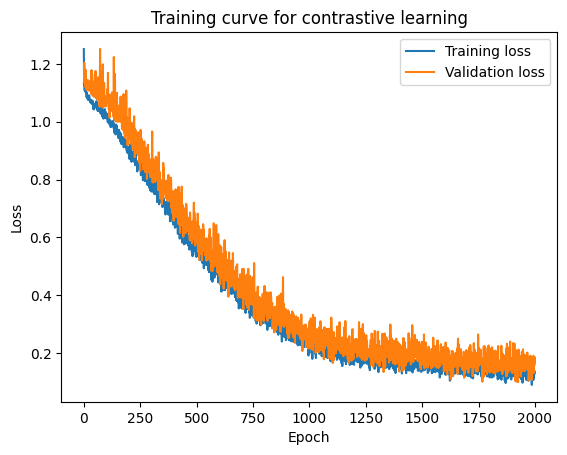

In [10]:
# Plot training curve
plt.figure()
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training curve for contrastive learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# save the model
torch.save(moco_model.state_dict(), 'saved_models/model_moco_v3.pth')
# Save the query encoder for downstream task
torch.save(moco_model.encoder_q.state_dict(), 'saved_encoders/encoder_q_v3.pth')

### Downstream Classification

In [ ]:
""" # load the trained model if need
moco_model.load_state_dict(torch.load('saved_models/model_moco_v3.pth')) """

C:\Users\Asus\AppData\Local\Temp\ipykernel_26184\1461392912.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  moco_model.load_state_dict(torch.load('saved_models/model_moc

<All keys matched successfully>

In [12]:
supervised_ratio = 0.1  # the proportion of the labeled data in training set to use for downstream classification
indices = list(range(len(train_set)))
train_labels = [data['Label'] for data in train_set] 
supervised_indices, _ = train_test_split(
    indices, 
    test_size=1 - supervised_ratio,  
    stratify=train_labels,          
    random_state=seed               
)

supervised_set = Subset(train_set, supervised_indices)
print(f'Number of labeled sequences used for supervised learning: {len(supervised_set)} ({100*supervised_ratio} % of training set)')

Number of labeled sequences used for supervised learning: 46 (10.0 % of training set)


In [14]:
# load data for downstream task
trainloader_supervised = DataLoader(supervised_set, batch_size=64, shuffle=True)
valloader_supervised = DataLoader(val_set, batch_size=64, shuffle=True)

In [15]:
# Define a simple classifier
class Classifier(nn.Module):
    def __init__(self, hidden_dim, num_classes = 16):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.classifier = nn.Linear(self.hidden_dim, self.num_classes)
    
    def forward(self,x):
        logits = self.classifier(x)
        return logits
    
classifier = Classifier(hidden_dim=128, num_classes=16).to(device)

In [16]:
for param in moco_model.encoder_q.parameters():
    param.requires_grad = False
    
# Training downstream classifier
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

train_loss, train_acc = [], []
val_loss, val_acc = [], []
n_epochs = 100
for epoch in tqdm(range(n_epochs)):
    classifier.train()
    moco_model.encoder_q.eval()

    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in trainloader_supervised:
        seqs = batch['Sequence'].float().to(device)
        labels = batch['Label'].to(device)
        
        optimizer.zero_grad()

        # Forward pass
        with torch.no_grad():
            feature = moco_model.encoder_q(seqs)
        
        output = classifier(feature)
        loss = loss_fn(output, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss.append(total_train_loss / len(trainloader_supervised))
    train_acc.append(correct_train / total_train)

    # Validation
    classifier.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): 
        for batch in valloader_supervised:
            seqs = batch['Sequence'].float().to(device)
            labels = batch['Label'].to(device)

            # Forward pass
            feature = moco_model.encoder_q(seqs)
            output = classifier(feature)
            loss = loss_fn(output, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss.append(total_val_loss / len(valloader_supervised))
    val_acc.append(correct_val / total_val)
  
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}]")
        print(f"  Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.4f}")
        print(f"  Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.4f}")


 11%|█         | 11/100 [00:00<00:05, 15.94it/s]

Epoch [10/100]
  Train Loss: 2.2455, Train Accuracy: 0.4348
  Val Loss: 2.3293, Val Accuracy: 0.3534


 23%|██▎       | 23/100 [00:01<00:03, 19.52it/s]

Epoch [20/100]
  Train Loss: 1.5755, Train Accuracy: 0.6304
  Val Loss: 1.8509, Val Accuracy: 0.5000


 32%|███▏      | 32/100 [00:01<00:03, 20.04it/s]

Epoch [30/100]
  Train Loss: 1.0938, Train Accuracy: 0.8696
  Val Loss: 1.5047, Val Accuracy: 0.6466


 41%|████      | 41/100 [00:02<00:02, 20.40it/s]

Epoch [40/100]
  Train Loss: 0.7677, Train Accuracy: 0.9783
  Val Loss: 1.2816, Val Accuracy: 0.6810


 53%|█████▎    | 53/100 [00:02<00:02, 20.46it/s]

Epoch [50/100]
  Train Loss: 0.5554, Train Accuracy: 0.9783
  Val Loss: 1.1452, Val Accuracy: 0.6638


 62%|██████▏   | 62/100 [00:03<00:01, 20.38it/s]

Epoch [60/100]
  Train Loss: 0.4191, Train Accuracy: 0.9783
  Val Loss: 1.0709, Val Accuracy: 0.6638


 71%|███████   | 71/100 [00:03<00:01, 20.36it/s]

Epoch [70/100]
  Train Loss: 0.3296, Train Accuracy: 0.9783
  Val Loss: 1.0170, Val Accuracy: 0.6466


 83%|████████▎ | 83/100 [00:04<00:00, 20.34it/s]

Epoch [80/100]
  Train Loss: 0.2681, Train Accuracy: 1.0000
  Val Loss: 0.9942, Val Accuracy: 0.6552


 92%|█████████▏| 92/100 [00:04<00:00, 20.50it/s]

Epoch [90/100]
  Train Loss: 0.2240, Train Accuracy: 1.0000
  Val Loss: 0.9562, Val Accuracy: 0.6552


100%|██████████| 100/100 [00:05<00:00, 18.90it/s]

Epoch [100/100]
  Train Loss: 0.1910, Train Accuracy: 1.0000
  Val Loss: 0.9583, Val Accuracy: 0.6552


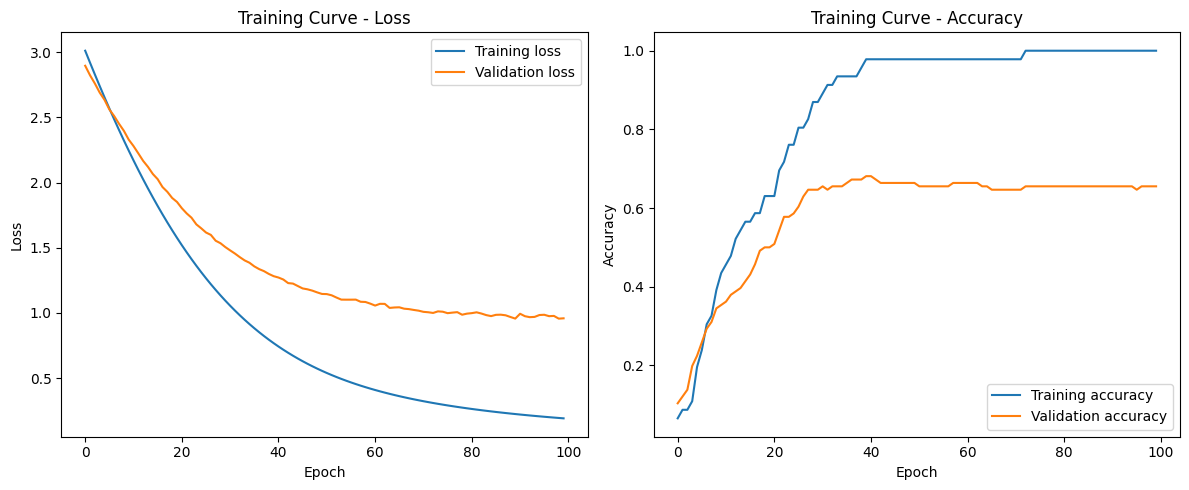

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

# Plot loss
axes[0].plot(train_loss, label='Training loss')
axes[0].plot(val_loss, label='Validation loss')
axes[0].set_title('Training Curve - Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot accuracy
axes[1].plot(train_acc, label='Training accuracy')
axes[1].plot(val_acc, label='Validation accuracy')
axes[1].set_title('Training Curve - Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()

### Evaluation on test set 

In [18]:
# Evaluation on test set
testloader = DataLoader(testset, batch_size=64, shuffle=True)

for param in moco_model.encoder_q.parameters():
    param.requires_grad = False

moco_model.encoder_q.eval()
classifier.eval()
total = 0
correct = 0

with torch.no_grad():
    for batch in testloader:
        seqs = batch['Sequence'].float().to(device)
        labels = batch['Label'].to(device)

        # Forward pass
        feature = moco_model.encoder_q(seqs)
        output = classifier(feature)

        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 67.19%


### Feature space visualization

**On train set**

In [10]:
features_list = []
labels_list = []

for param in moco_model.encoder_q.parameters():
    param.requires_grad = False

moco_model.encoder_q.eval()

with torch.no_grad():
    for batch in trainloader_ssl:
        seqs = batch['Sequence'].float().to(device)
        labels = batch['Label'].to(device)

        # Forward pass
        feature = moco_model.encoder_q(seqs)

        features_list.append(feature.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Stack all features and labels
features = np.concatenate(features_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

C:\Users\Asus\AppData\Local\Temp\ipykernel_26184\394316729.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('tab20', 16))


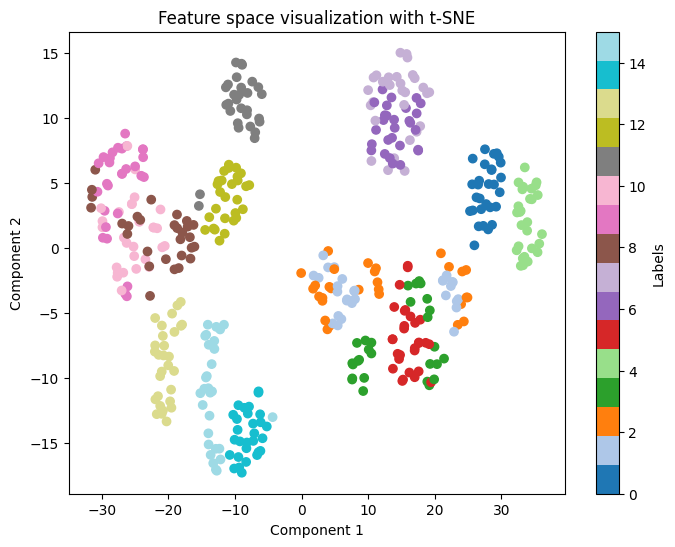

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=35)
features_tsne = tsne.fit_transform(features)

# Visualization for all gestures
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('tab20', 16))
plt.colorbar(label="Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Feature space visualization with t-SNE")
plt.show()


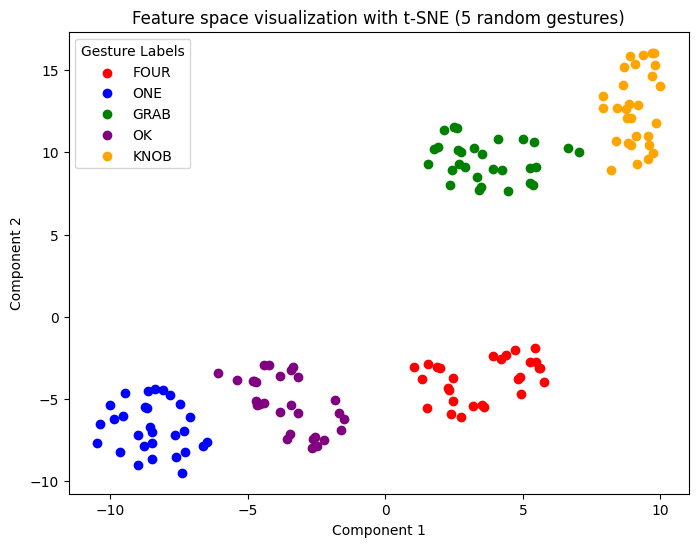

In [12]:
random.seed(seed)                
np.random.seed(seed) 

# Define label mapping
label_map = [
    "ONE", "TWO", "THREE", "FOUR", "OK", "MENU",
    "LEFT", "RIGHT", "CIRCLE", "V", "CROSS", "GRAB",
    "PINCH", "DENY", "WAVE", "KNOB"
]

# Select 5 random labels for visualization
unique_labels = np.unique(labels)
selected_labels = random.sample(list(unique_labels), 5) 

# Filter features and labels for selected classes
m = np.isin(labels, selected_labels)
features5 = features[m]
labels5 = labels[m]

# Dimensional reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features5)

# Assign colors
colors = ['red', 'blue', 'green', 'purple', 'orange']
label_to_color = {label: colors[i] for i, label in enumerate(selected_labels)}

# Plot the features visualization
plt.figure(figsize=(8, 6))
for label in selected_labels:
    idx = labels5 == label
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], 
                color=label_to_color[label], label=label_map[label])

plt.legend(title="Gesture Labels", loc="best")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title(f"Feature space visualization with t-SNE (5 random gestures)")
plt.show()


**On test set**

In [15]:
features_list = []
labels_list = []

for param in moco_model.encoder_q.parameters():
    param.requires_grad = False

moco_model.encoder_q.eval()

with torch.no_grad():
    for batch in testloader:
        seqs = batch['Sequence'].float().to(device)
        labels = batch['Label'].to(device)

        # Forward pass
        feature = moco_model.encoder_q(seqs)

        features_list.append(feature.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Stack all features and labels
features = np.concatenate(features_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

C:\Users\Asus\AppData\Local\Temp\ipykernel_26184\2722010592.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('tab20', 16))


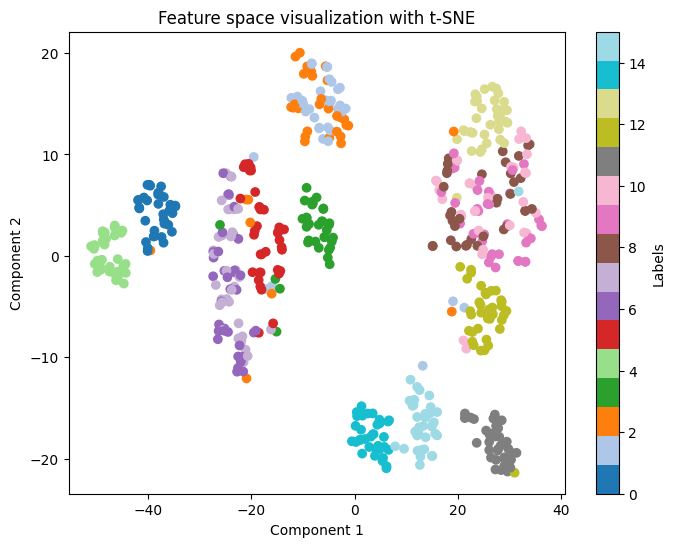

In [16]:
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

# Visualization for all gestures
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('tab20', 16))
plt.colorbar(label="Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Feature space visualization with t-SNE")
plt.show()


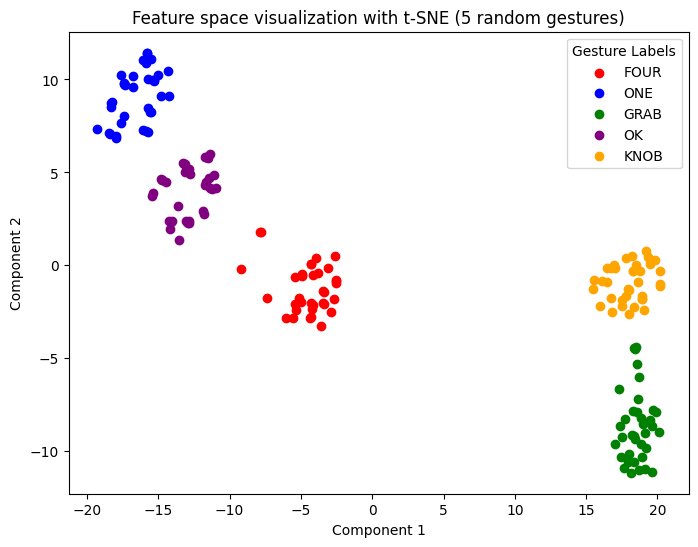

In [17]:
random.seed(seed)                
np.random.seed(seed) 

# Filter features and labels for selected classes
m = np.isin(labels, selected_labels)
features5 = features[m]
labels5 = labels[m]

# Dimensional reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features5)

# Assign colors
colors = ['red', 'blue', 'green', 'purple', 'orange']
label_to_color = {label: colors[i] for i, label in enumerate(selected_labels)}

# Plot the features visualization
plt.figure(figsize=(8, 6))
for label in selected_labels:
    idx = labels5 == label
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], 
                color=label_to_color[label], label=label_map[label])

plt.legend(title="Gesture Labels", loc="best")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title(f"Feature space visualization with t-SNE (5 random gestures)")
plt.show()


## MoCo with dynamic temperature

In [18]:
# Load base encoder for MoCo
base_encoder_2 = STGCN_model(in_channels=3, 
                           hidden_channels=16, 
                           hidden_dim=64, out_dim=128, 
                           graph_args=graph_args, 
                           edge_importance_weighting=True,
                           dropout_rate=0).to(device)

# Load MoCo Model
moco_dynamic_tem = MoCo_model(base_encoder=base_encoder_2, 
                  dim = 128,
                  mlp_dim=256,  
                  m=momentum, 
                  T_max=0.2,
                  T_min=0.05,
                  T_type='dynamic').to(device)

In [27]:
n_epochs = 2000

### Self-supervised training with InfoNCE loss
optimizer = optim.Adam(moco_dynamic_tem.parameters(), lr=learning_rate)

train_loss, val_loss = [], []
for epoch in tqdm(range(n_epochs)):
    # Training
    moco_dynamic_tem.train()
    total_train_loss = 0.0
    for batch in trainloader_ssl:
        seqs = batch['Sequence'].float().to(device)
        seqs_aug1 = augmentations1(seqs)
        seqs_aug2 = augmentations1(seqs)
        optimizer.zero_grad()

        # Forward pass
        loss = moco_dynamic_tem(seqs_aug1, seqs_aug2, training=True)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    train_loss.append(total_train_loss/len(trainloader_ssl))

    # Validation
    moco_dynamic_tem.eval()
    total_val_loss = 0.0

    with torch.no_grad(): 
        for batch in valloader_ssl:
            seqs = batch['Sequence'].float().to(device)
            seqs_aug1 = augmentations1(seqs)
            seqs_aug2 = augmentations1(seqs)
            
            # Forward pass
            loss = moco_dynamic_tem(seqs_aug1, seqs_aug2, training=False)
            total_val_loss += loss.item()

    val_loss.append(total_val_loss/len(valloader_ssl))
  
    if (epoch + 1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}]")
        print(f"  Train Loss: {train_loss[-1]:.4f}")
        print(f"  Val Loss: {val_loss[-1]:.4f}")


 10%|█         | 200/2000 [05:44<51:08,  1.70s/it]

Epoch [200/2000]
  Train Loss: 0.6588
  Val Loss: 0.6696


 20%|██        | 400/2000 [11:29<45:57,  1.72s/it]

Epoch [400/2000]
  Train Loss: 0.4937
  Val Loss: 0.5148


 30%|███       | 600/2000 [17:13<40:07,  1.72s/it]

Epoch [600/2000]
  Train Loss: 0.3714
  Val Loss: 0.4234


 40%|████      | 800/2000 [22:57<34:21,  1.72s/it]

Epoch [800/2000]
  Train Loss: 0.3395
  Val Loss: 0.3729


 50%|█████     | 1000/2000 [28:41<28:29,  1.71s/it]

Epoch [1000/2000]
  Train Loss: 0.3176
  Val Loss: 0.3665


 60%|██████    | 1200/2000 [34:26<23:25,  1.76s/it]

Epoch [1200/2000]
  Train Loss: 0.3087
  Val Loss: 0.3220


 70%|███████   | 1400/2000 [40:19<17:05,  1.71s/it]

Epoch [1400/2000]
  Train Loss: 0.2978
  Val Loss: 0.3242


 80%|████████  | 1600/2000 [46:02<11:31,  1.73s/it]

Epoch [1600/2000]
  Train Loss: 0.2836
  Val Loss: 0.3154


 90%|█████████ | 1800/2000 [52:00<05:46,  1.73s/it]

Epoch [1800/2000]
  Train Loss: 0.2685
  Val Loss: 0.3021


100%|██████████| 2000/2000 [57:46<00:00,  1.73s/it]

Epoch [2000/2000]
  Train Loss: 0.2665
  Val Loss: 0.3003


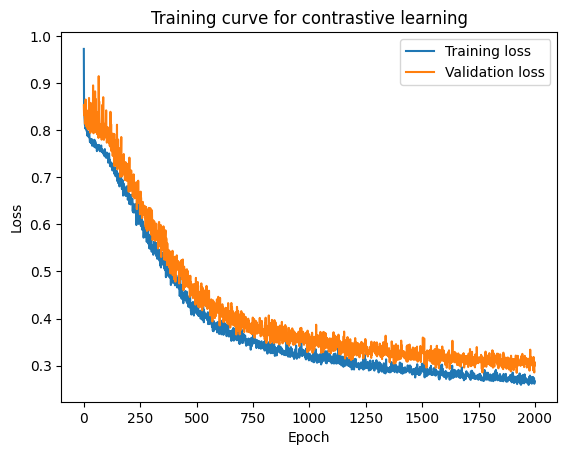

In [28]:
# Plot training curve
plt.figure()
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training curve for contrastive learning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# save the model
torch.save(moco_dynamic_tem.state_dict(), 'saved_models/model_moco_v3_dynamic.pth')
# Save the query encoder for downstream task
torch.save(moco_dynamic_tem.encoder_q.state_dict(), 'saved_encoders/encoder_q_v3_dynamic.pth')

### Downstream Classification

In [ ]:
""" # load the trained model if need
moco_dynamic_tem.load_state_dict(torch.load('saved_models/model_moco_v3_dynamic.pth')) """

C:\Users\Asus\AppData\Local\Temp\ipykernel_26184\2719688702.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  moco_dynamic_tem.load_state_dict(torch.load('saved_models/mod

<All keys matched successfully>

In [35]:
classifier = Classifier(hidden_dim=128, num_classes=16).to(device)
for param in moco_dynamic_tem.encoder_q.parameters():
    param.requires_grad = False
    
# Training downstream classifier
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

train_loss, train_acc = [], []
val_loss, val_acc = [], []
n_epochs = 100
for epoch in tqdm(range(n_epochs)):
    classifier.train()
    moco_dynamic_tem.encoder_q.eval()

    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in trainloader_supervised:
        seqs = batch['Sequence'].float().to(device)
        labels = batch['Label'].to(device)
        
        optimizer.zero_grad()

        # Forward pass
        with torch.no_grad():
            feature = moco_dynamic_tem.encoder_q(seqs)
        
        output = classifier(feature)
        loss = loss_fn(output, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss.append(total_train_loss / len(trainloader_supervised))
    train_acc.append(correct_train / total_train)

    # Validation
    classifier.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): 
        for batch in valloader_supervised:
            seqs = batch['Sequence'].float().to(device)
            labels = batch['Label'].to(device)

            # Forward pass
            feature = moco_dynamic_tem.encoder_q(seqs)
            output = classifier(feature)
            loss = loss_fn(output, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss.append(total_val_loss / len(valloader_supervised))
    val_acc.append(correct_val / total_val)
  
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}]")
        print(f"  Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.4f}")
        print(f"  Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {val_acc[-1]:.4f}")


 13%|█▎        | 13/100 [00:00<00:04, 18.50it/s]

Epoch [10/100]
  Train Loss: 2.1303, Train Accuracy: 0.3478
  Val Loss: 2.2764, Val Accuracy: 0.3103


 21%|██        | 21/100 [00:01<00:04, 19.71it/s]

Epoch [20/100]
  Train Loss: 1.4763, Train Accuracy: 0.7391
  Val Loss: 1.7975, Val Accuracy: 0.5776


 33%|███▎      | 33/100 [00:01<00:03, 20.50it/s]

Epoch [30/100]
  Train Loss: 1.0077, Train Accuracy: 0.9130
  Val Loss: 1.4154, Val Accuracy: 0.6810


 42%|████▏     | 42/100 [00:02<00:02, 20.56it/s]

Epoch [40/100]
  Train Loss: 0.7000, Train Accuracy: 0.9565
  Val Loss: 1.1711, Val Accuracy: 0.7328


 54%|█████▍    | 54/100 [00:02<00:02, 20.35it/s]

Epoch [50/100]
  Train Loss: 0.5039, Train Accuracy: 0.9565
  Val Loss: 0.9968, Val Accuracy: 0.7586


 63%|██████▎   | 63/100 [00:03<00:01, 20.70it/s]

Epoch [60/100]
  Train Loss: 0.3792, Train Accuracy: 0.9565
  Val Loss: 0.8885, Val Accuracy: 0.7414


 72%|███████▏  | 72/100 [00:03<00:01, 20.52it/s]

Epoch [70/100]
  Train Loss: 0.2979, Train Accuracy: 0.9783
  Val Loss: 0.8210, Val Accuracy: 0.7414


 81%|████████  | 81/100 [00:04<00:00, 20.59it/s]

Epoch [80/100]
  Train Loss: 0.2426, Train Accuracy: 0.9783
  Val Loss: 0.7829, Val Accuracy: 0.7759


 93%|█████████▎| 93/100 [00:04<00:00, 20.52it/s]

Epoch [90/100]
  Train Loss: 0.2034, Train Accuracy: 0.9783
  Val Loss: 0.7506, Val Accuracy: 0.7931


100%|██████████| 100/100 [00:05<00:00, 19.63it/s]

Epoch [100/100]
  Train Loss: 0.1742, Train Accuracy: 1.0000
  Val Loss: 0.7262, Val Accuracy: 0.8017


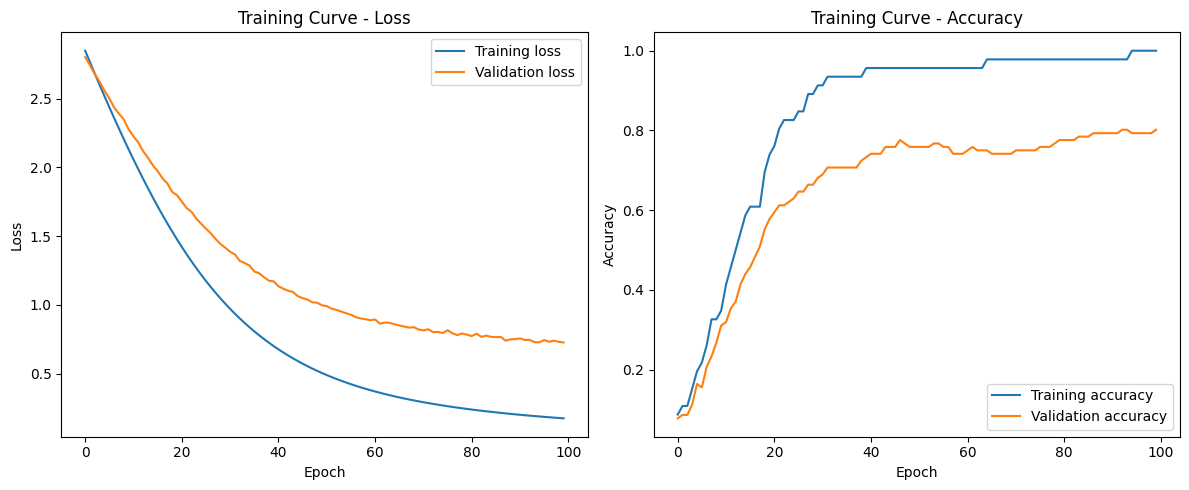

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

# Plot loss
axes[0].plot(train_loss, label='Training loss')
axes[0].plot(val_loss, label='Validation loss')
axes[0].set_title('Training Curve - Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot accuracy
axes[1].plot(train_acc, label='Training accuracy')
axes[1].plot(val_acc, label='Validation accuracy')
axes[1].set_title('Training Curve - Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()

### Evaluation on test set 

In [38]:
# Evaluation on test set
testloader = DataLoader(testset, batch_size=64, shuffle=True)

for param in moco_dynamic_tem.encoder_q.parameters():
    param.requires_grad = False

moco_dynamic_tem.encoder_q.eval()
classifier.eval()
total = 0
correct = 0

with torch.no_grad():
    for batch in testloader:
        seqs = batch['Sequence'].float().to(device)
        labels = batch['Label'].to(device)

        # Forward pass
        feature = moco_dynamic_tem.encoder_q(seqs)
        output = classifier(feature)

        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 74.13%


### Feature space visualization

**On train set**

In [20]:
features_list = []
labels_list = []

for param in moco_dynamic_tem.encoder_q.parameters():
    param.requires_grad = False

moco_dynamic_tem.encoder_q.eval()

with torch.no_grad():
    for batch in trainloader_ssl:
        seqs = batch['Sequence'].float().to(device)
        labels = batch['Label'].to(device)

        # Forward pass
        feature = moco_dynamic_tem.encoder_q(seqs)

        features_list.append(feature.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Stack all features and labels
features = np.concatenate(features_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

C:\Users\Asus\AppData\Local\Temp\ipykernel_26184\3556692995.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('tab20', 16))


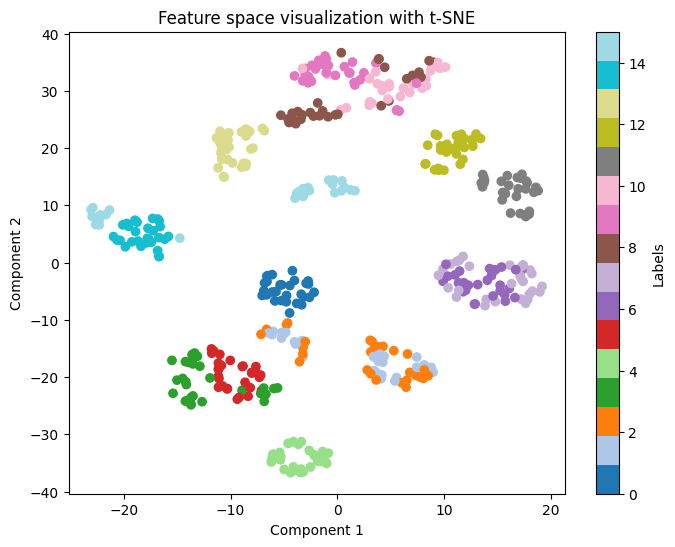

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

# Visualization for all gestures
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('tab20', 16))
plt.colorbar(label="Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Feature space visualization with t-SNE")
plt.show()


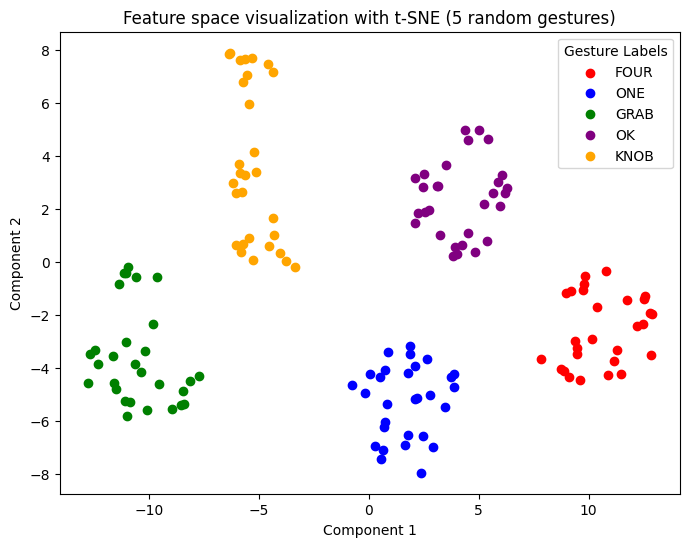

In [22]:
random.seed(seed)                
np.random.seed(seed) 

# Define label mapping
label_map = [
    "ONE", "TWO", "THREE", "FOUR", "OK", "MENU",
    "LEFT", "RIGHT", "CIRCLE", "V", "CROSS", "GRAB",
    "PINCH", "DENY", "WAVE", "KNOB"
]

# Select 5 random labels for visualization
unique_labels = np.unique(labels)
selected_labels = random.sample(list(unique_labels), 5) 

# Filter features and labels for selected classes
m = np.isin(labels, selected_labels)
features5 = features[m]
labels5 = labels[m]

# Dimensional reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features5)

# Assign colors
colors = ['red', 'blue', 'green', 'purple', 'orange']
label_to_color = {label: colors[i] for i, label in enumerate(selected_labels)}

# Plot the features visualization
plt.figure(figsize=(8, 6))
for label in selected_labels:
    idx = labels5 == label
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], 
                color=label_to_color[label], label=label_map[label])

plt.legend(title="Gesture Labels", loc="best")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title(f"Feature space visualization with t-SNE (5 random gestures)")
plt.show()


**On test set**

In [23]:
features_list = []
labels_list = []

for param in moco_dynamic_tem.encoder_q.parameters():
    param.requires_grad = False

moco_dynamic_tem.encoder_q.eval()

with torch.no_grad():
    for batch in testloader:
        seqs = batch['Sequence'].float().to(device)
        labels = batch['Label'].to(device)

        # Forward pass
        feature = moco_dynamic_tem.encoder_q(seqs)

        features_list.append(feature.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Stack all features and labels
features = np.concatenate(features_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

C:\Users\Asus\AppData\Local\Temp\ipykernel_26184\2722010592.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('tab20', 16))


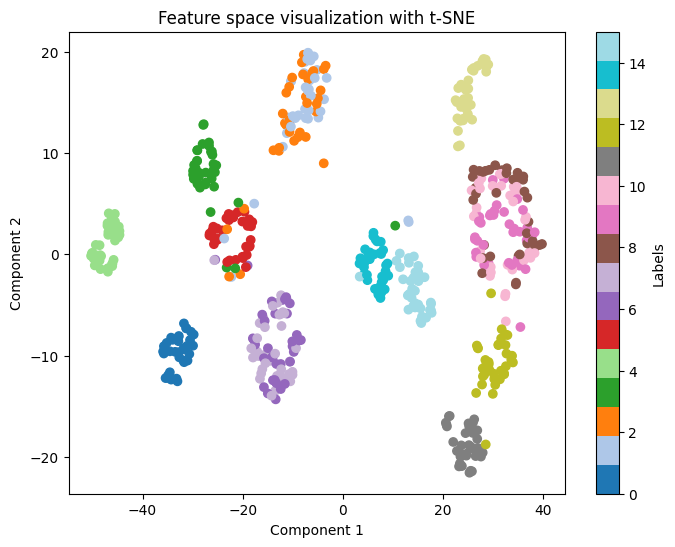

In [24]:
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

# Visualization for all gestures
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('tab20', 16))
plt.colorbar(label="Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Feature space visualization with t-SNE")
plt.show()


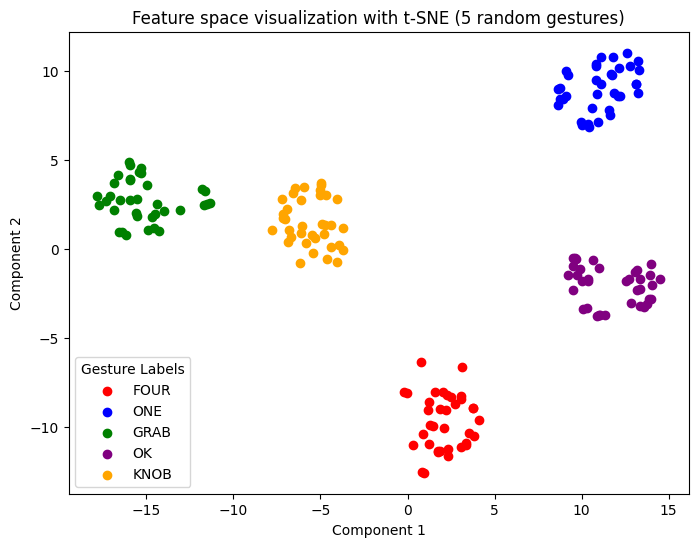

In [25]:
random.seed(seed)                
np.random.seed(seed) 

# Filter features and labels for selected classes
m = np.isin(labels, selected_labels)
features5 = features[m]
labels5 = labels[m]

# Dimensional reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features5)

# Assign colors
colors = ['red', 'blue', 'green', 'purple', 'orange']
label_to_color = {label: colors[i] for i, label in enumerate(selected_labels)}

# Plot the features visualization
plt.figure(figsize=(8, 6))
for label in selected_labels:
    idx = labels5 == label
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], 
                color=label_to_color[label], label=label_map[label])

plt.legend(title="Gesture Labels", loc="best")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title(f"Feature space visualization with t-SNE (5 random gestures)")
plt.show()
